In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from zoobot.estimators import mixture_stats, dirichlet_stats

## Pairwise KL (TFP)

In [4]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Dirichlet#kl_divergence
# https://github.com/tensorflow/probability/blob/v0.10.1/tensorflow_probability/python/distributions/dirichlet.py#L354
p = tfp.distributions.Dirichlet(np.random.rand(3))
q = tfp.distributions.Dirichlet(np.random.rand(3))
p.kl_divergence(q)

<tf.Tensor: shape=(), dtype=float64, numpy=1.6897230184338479>

In [5]:
p = tfp.distributions.Dirichlet([12., 14., 3.])
q = tfp.distributions.Dirichlet([3., 14., 12.])
p.kl_divergence(q)

<tf.Tensor: shape=(), dtype=float32, numpy=13.678894>

In [41]:
mixture_stats.dirichlet_kl_div(np.array([12., 14., 3.]), np.array([3., 14., 12.])).numpy()

13.678896103896108

In [8]:
# https://github.com/tensorflow/probability/blob/v0.10.1/tensorflow_probability/python/distributions/dirichlet.py#L237
# immplementing https://en.wikipedia.org/wiki/Dirichlet_distribution#Entropy
tfp.distributions.Dirichlet([3., 14., 12.], validate_args=True).entropy().numpy()  # differential so can be negative

-2.5960693

In [9]:
# my copied version (note the lbeta, digamma tricks)
def dirichlet_entropy(concentration):
    k = len(concentration)
    total_concentration = concentration.sum()
    return (tf.math.lbeta(concentration) +
            ((total_concentration - k) * tf.math.digamma(total_concentration)) -
            tf.reduce_sum((concentration - 1.) * tf.math.digamma(concentration),
                          axis=-1)).numpy()

In [10]:
dirichlet_entropy(np.array([3., 14., 12.]))

-2.5960668548883206

## Pairwise Chernoff distance (custom)

In [11]:
mixture_stats.dirichlet_chernoff(np.array([1, 2, 3]), np.array([3, 2, 1]), lam=0.5)

0.6931471805599454

In [12]:

mixture_stats.dirichlet_chernoff(np.array([1, 2, 10]), np.array([30, 2, 1]), lam=0.5)

9.233299140837175

In [13]:

mixture_stats.dirichlet_chernoff(np.array([1, 2, 1]), np.array([1, 2, 1]), lam=0.5)

-0.0

In [14]:

%timeit mixture_stats.dirichlet_chernoff(np.array([1, 2, 1]), np.array([1, 2, 1]), lam=0.5)

37 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
weights = np.ones(3) / np.ones(3).sum()

In [16]:
# alphas_2_answers_3_models = np.array([[1., 2.], [1.5, 1.5], [2., 1.]])
answer_model = np.array([[2., 18.], [4, 15], [3., 16.]]).transpose()
answer_model.shape


(2, 3)

In [17]:
[x for x in answer_model]

[array([2., 4., 3.]), array([18., 15., 16.])]

In [18]:
mixture_stats.entropy_given_components(answer_model, weights)

-1.2083379349001881

In [45]:
!pip install line_profiler

     |████████████████████████████████| 68 kB 1.3 MB/s eta 0:00:011


In [46]:


%load_ext line_profiler



In [20]:
mixture_stats.distance_term(answer_model, weights=weights, distance_func=mixture_stats.dirichlet_kl_div)

-0.295267279738745

In [23]:
mixture_stats.distance_term(answer_model, weights=weights, distance_func=lambda x, y: mixture_stats.dirichlet_chernoff(x, y, lam=.5))

-0.08492450054555271

In [25]:
mixture_stats.entropy_lower_bound(answer_model, weights=weights), mixture_stats.entropy_upper_bound(answer_model, weights=weights)

(-1.1234134343546354, -0.9130706551614431)

In [59]:
!pip install numba

In [26]:
%timeit mixture_stats.entropy_lower_bound(answer_model, weights=weights)

3.25 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%lprun -f mixture_stats.entropy_given_components mixture_stats.entropy_upper_bound(answer_model, weights=weights)

Timer unit: 1e-06 s

Total time: 0.015654 s
File: /home/walml/repos/zoobot/zoobot/estimators/mixture_stats.py
Function: entropy_given_components at line 85

Line #      Hits         Time  Per Hit   % Time  Line Contents
    85                                           def entropy_given_components(answer_model, weights):
    86         1      10722.0  10722.0     68.5      list_of_alphas = tf.transpose(answer_model)
    87         1       4932.0   4932.0     31.5      return np.sum(weights * np.array([tfp.distributions.Dirichlet(alpha).entropy() for alpha in list_of_alphas]))

In [57]:
%lprun -f mixture_stats.distance_term mixture_stats.entropy_upper_bound(answer_model, weights=weights)

Timer unit: 1e-06 s

Total time: 0.016074 s
File: /home/walml/repos/zoobot/zoobot/estimators/mixture_stats.py
Function: distance_term at line 16

Line #      Hits         Time  Per Hit   % Time  Line Contents
    16                                           def distance_term(answer_model, weights, distance_func):
    17         1          2.0      2.0      0.0      n_dim = len(weights)
    18         1          4.0      4.0      0.0      i_terms = np.zeros(len(weights))
    19         4          2.0      0.5      0.0      for i in range(n_dim):
    20         3         12.0      4.0      0.1          j_terms = np.zeros(len(weights))
    21        12         29.0      2.4      0.2          for j in range(n_dim):
    22                                                       # the i=j term is not 0, don't skip it
    23         9      14013.0   1557.0     87.2              distance = distance_func(answer_model[:, i], answer_model[:, j])
    24         9       1810.0    201.1     11.3      

In [58]:
%lprun -f mixture_stats.entropy_upper_bound mixture_stats.entropy_upper_bound(answer_model, weights=weights)

Timer unit: 1e-06 s

Total time: 0.022466 s
File: /home/walml/repos/zoobot/zoobot/estimators/mixture_stats.py
Function: entropy_upper_bound at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def entropy_upper_bound(arr_of_alphas, weights):
     9         1      22466.0  22466.0    100.0      return entropy_given_components(arr_of_alphas, weights) - distance_term(arr_of_alphas, weights, distance_func=dirichlet_kl_div)

In [67]:
from zoobot.estimators.dirichlet_stats import DirichletEqualMixture

In [69]:
# alphas = np.expand_dims(arr_of_alphas.transpose(), axis=0)
# alphas.shape  # batch, answers, models

In [70]:
# mixture = DirichletEqualMixture(alphas) 
# mixture.prob(np.expand_dims([0.3, 0.6, 0.1], axis=0))

In [81]:
import scipy.integrate as integrate

def numerical_entropy(answer_model):  # equal weights
    
    batch_answer_model = np.expand_dims(answer_model, axis=0)
#     print(batch_answer_model.shape)
    mixture = dirichlet_stats.DirichletEqualMixture(batch_answer_model)  # batch dim = 1
    entropy_func = lambda x: -mixture.mean_prob(np.array([x, 1-x])) * mixture.mean_log_prob(np.array([x, 1-x]))
    result = integrate.quad(entropy_func, 0, 1)
    return result[0]

In [82]:
numerical_entropy(answer_model)

-1.0660501697854963

In [83]:
import pandas as pd

df = pd.read_csv('/home/walml/repos/zoobot/temp/decals_n2_allq_m0.csv')  # same real predictions
df = df.sample(len(df))  # shuffle

In [159]:
from zoobot import label_metadata
from zoobot.estimators import dirichlet_stats

In [160]:
concentration_cols = [a + '_concentration' for a in label_metadata.decals_label_cols]

In [161]:
concentrations = dirichlet_stats.load_all_concentrations(df, concentration_cols)
concentrations.shape

(10000, 34, 5)

In [162]:
all_alphas = concentrations[:100, 5:7]  # has_spiral_arms

In [163]:
weights = np.ones(5) * 0.2
data = []
for n in range(0, 10):
    answer_model = all_alphas[n]
    lower = mixture_stats.entropy_lower_bound(answer_model, weights=weights)
    upper = mixture_stats.entropy_upper_bound(answer_model, weights=weights)
    actual = numerical_entropy(answer_model)
    print('{:.3f} <= {:.3f} <= {:.3f}'.format(lower, actual, upper))
    result = {}
    result['galaxy'] = n
    result['lower'] = lower
    result['upper'] = upper
    result['actual'] = actual
    data.append(result)
e = pd.DataFrame(data)

-0.549 <= -0.485 <= -0.352
-0.664 <= -0.651 <= -0.623
-0.597 <= -0.585 <= -0.562
-0.985 <= -0.957 <= -0.897
-0.835 <= -0.808 <= -0.751
-0.511 <= -0.446 <= -0.306
-2.372 <= -2.363 <= -2.346
-0.960 <= -0.901 <= -0.777
-0.716 <= -0.706 <= -0.684
-0.788 <= -0.777 <= -0.754


In [164]:
e

,galaxy,lower,upper,actual
0,0,-0.549051,-0.351861,-0.485023
1,1,-0.663523,-0.623418,-0.650689
2,2,-0.596766,-0.561716,-0.585281
3,3,-0.985200,-0.896957,-0.956962
4,4,-0.834662,-0.750925,-0.807906
5,5,-0.511441,-0.305562,-0.445836
6,6,-2.371629,-2.346186,-2.363307
7,7,-0.960317,-0.776642,-0.900755
8,8,-0.715538,-0.684436,-0.705563
9,9,-0.788377,-0.753583,-0.776748


In [165]:
e['midpoint'] = e['lower'] + (e['upper'] - e['lower'])/2 
e['offset'] = e['actual'] - e['midpoint']  
mean_offset = e['offset'].mean()

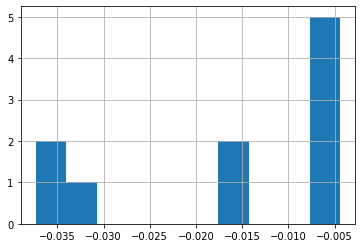

In [166]:
e['offset'].hist()

In [167]:
e['actual_offset'] = e['actual'] - mean_offset

In [168]:
e['midpoint'].values

array([-0.45045593, -0.64347019, -0.57924095, -0.94107859, -0.79279359,
       -0.40850155, -2.35890763, -0.86847949, -0.69998698, -0.7709799 ])

In [169]:
e = e.sort_values('midpoint').reset_index(drop=True)

In [170]:
e['rank'] = e.index

In [171]:
e

,galaxy,lower,upper,actual,midpoint,offset,actual_offset,rank
0,6,-2.371629,-2.346186,-2.363307,-2.358908,-0.004399,-2.346890,0
1,3,-0.985200,-0.896957,-0.956962,-0.941079,-0.015884,-0.940545,1
2,7,-0.960317,-0.776642,-0.900755,-0.868479,-0.032275,-0.884337,2
3,4,-0.834662,-0.750925,-0.807906,-0.792794,-0.015112,-0.791489,3
4,9,-0.788377,-0.753583,-0.776748,-0.770980,-0.005768,-0.760330,4
5,8,-0.715538,-0.684436,-0.705563,-0.699987,-0.005576,-0.689146,5
6,1,-0.663523,-0.623418,-0.650689,-0.643470,-0.007219,-0.634272,6
7,2,-0.596766,-0.561716,-0.585281,-0.579241,-0.006040,-0.568863,7
8,0,-0.549051,-0.351861,-0.485023,-0.450456,-0.034567,-0.468605,8
9,5,-0.511441,-0.305562,-0.445836,-0.408502,-0.037335,-0.429419,9


In [172]:
import seaborn as sns

Text(0.5, 0, 'Galaxy (rank)')

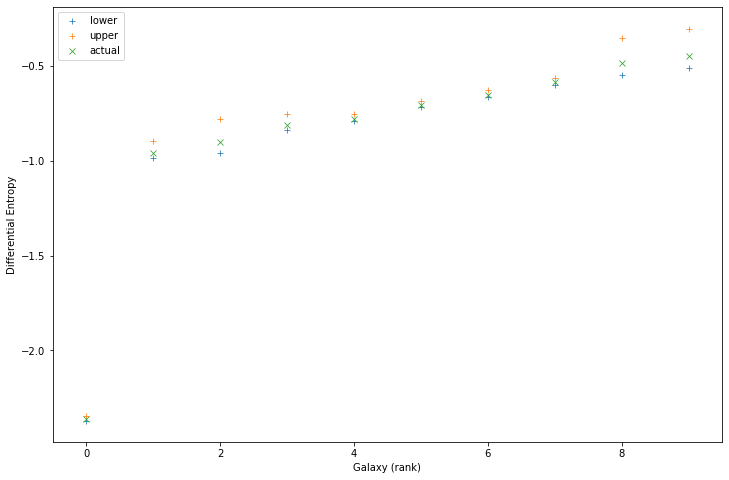

In [173]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=e, x='rank', y='lower', label='lower', marker='+', ax=ax)
sns.scatterplot(data=e, x='rank', y='upper', label='upper', marker='+', ax=ax)
sns.scatterplot(data=e, x='rank', y='actual', label='actual', marker='x', ax=ax)
# sns.scatterplot(data=e, x='rank', y='actual_offset', label='actual_offset', marker='x', ax=ax)
plt.legend()
plt.ylabel('Differential Entropy')
plt.xlabel('Galaxy (rank)')

Can now calculate 'entropy of whole mixture' term, and already knew average entropy of each component, so MI known.
Remains to be tested if the error in the mixture entropy is smaller than the mixture entropy - average entropy variation

In [174]:
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata
from zoobot.estimators import losses

In [175]:
# decals cols
questions = label_metadata.decals_questions
version = 'decals'
label_cols = label_metadata.decals_label_cols

# gz2 cols
# questions = label_metadata.gz2_questions
# version = 'gz2'
# label_cols = label_metadata.gz2_label_cols



schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [176]:
print(concentrations.shape)

(10000, 34, 5)


In [185]:
concentrations_cut = concentrations.astype(np.float32)[:100]
samples_list = [concentrations_cut, concentrations_cut + np.random.rand(*concentrations_cut.shape)]

In [186]:
concentrations_cut.shape

(100, 34, 5)

In [187]:
mi, predictive, expected = acquisition_utils.get_multimodel_acq(samples_list, schema)

smooth-or-featured
Calculating predictive entropy
Calculating expected entropy


Calculating joint p of being asked
has-spiral-arms
Calculating predictive entropy
Calculating expected entropy
Calculating joint p of being asked
bar
Calculating predictive entropy
Calculating expected entropy
Calculating joint p of being asked
bulge-size
Calculating predictive entropy
Calculating expected entropy


Calculating joint p of being asked


In [188]:
predictive.shape, expected.shape

((100, 4), (100, 4))

In [189]:
mi.shape

(100, 4)

In [190]:
expected

array([[ -2.68519668,  -0.49891518,  -1.84529885,  -7.06700113],
       [ -3.11963945,  -0.64634737,  -3.09750469,  -8.94095922],
       [ -3.11249568,  -0.58956897,  -2.96697336,  -8.72229828],
       [ -3.09089189,  -0.9027819 ,  -1.96608695, -10.32378614],
       [ -4.16451508,  -0.78854599,  -4.44639261,  -7.00549797],
       [ -3.10252563,  -0.4106918 ,  -4.90679756,  -9.07237766],
       [ -3.78109782,  -2.25849747,  -2.46322675,  -9.10447209],
       [ -4.24569935,  -0.85942494,  -3.8937461 ,  -7.42340108],
       [ -3.40083414,  -0.7041205 ,  -3.07806841,  -9.96670384],
       [ -3.26466055,  -0.76708154,  -2.08420836, -11.00645117],
       [ -4.33471238,  -2.52066879,  -5.39304625, -10.52670628],
       [ -3.66097236,  -0.98352536,  -2.92292196,  -6.80564493],
       [ -2.49976652,  -0.40922369,  -2.67851269,  -8.0020479 ],
       [ -2.92571485,  -1.34988406,  -3.41383319,  -9.52317482],
       [ -3.40384343,  -0.79479311,  -3.68303757,  -6.44338085],
       [ -2.9020347 ,  -0

In [191]:
predictive

array([[ -2.68248444,  -0.49466054,  -1.83624637,  -7.04003045],
       [ -3.11215371,  -0.64576471,  -3.07452443,  -8.93304184],
       [ -3.10146236,  -0.58484454,  -2.95621088,  -8.68125223],
       [ -3.07307848,  -0.89068753,  -1.96374802, -10.29525968],
       [ -4.15299019,  -0.78559744,  -4.41893828,  -7.00350187],
       [ -3.09822534,  -0.41050312,  -4.89794243,  -9.04476927],
       [ -3.77714682,  -2.23801631,  -2.45633997,  -9.06428701],
       [ -4.2355938 ,  -0.85536781,  -3.88045099,  -7.41252977],
       [ -3.39658644,  -0.70354913,  -3.04201724,  -9.94201554],
       [ -3.25395955,  -0.76522924,  -2.08154394, -10.96081814],
       [ -4.33163425,  -2.49819449,  -5.36577322, -10.46738745],
       [ -3.65602351,  -0.97977298,  -2.91350855,  -6.79538401],
       [ -2.4919961 ,  -0.4023908 ,  -2.65803564,  -7.96994663],
       [ -2.92314769,  -1.34811629,  -3.39995969,  -9.50004852],
       [ -3.39518527,  -0.79125912,  -3.65936182,  -6.44037078],
       [ -2.89548608,  -0

In [192]:
mi

array([[2.71223817e-03, 2.37314346e-03, 5.04927257e-03, 1.50436564e-02],
       [7.48573894e-03, 1.79034618e-04, 7.06112570e-03, 2.43276708e-03],
       [1.10333198e-02, 2.67967741e-04, 6.10443276e-04, 2.32811495e-03],
       [1.78134047e-02, 7.76745655e-03, 1.50214380e-03, 1.83207543e-02],
       [1.15248943e-02, 2.22555545e-04, 2.07224711e-03, 1.50665172e-04],
       [4.30029838e-03, 4.93515810e-05, 2.31618452e-03, 7.22136978e-03],
       [3.95100334e-03, 7.96468344e-04, 2.67812010e-04, 1.56271146e-03],
       [1.01055433e-02, 2.34311882e-04, 7.67832616e-04, 6.27851475e-04],
       [4.24769614e-03, 1.02853927e-04, 6.48962335e-03, 4.44417751e-03],
       [1.07010028e-02, 5.53167603e-04, 7.95700153e-04, 1.36278154e-02],
       [3.07813077e-03, 1.90423458e-03, 2.31082867e-03, 5.02605152e-03],
       [4.94885645e-03, 6.87854595e-05, 1.72558709e-04, 1.88094449e-04],
       [7.77042143e-03, 1.60705067e-03, 4.81606836e-03, 7.55000803e-03],
       [2.56716714e-03, 8.35213167e-04, 6.55478396e

(array([ 4., 20., 21., 17., 25.,  9.,  2.,  1.,  0.,  1.]),
 array([-4.73346373, -4.38818208, -4.04290043, -3.69761878, -3.35233713,
        -3.00705548, -2.66177383, -2.31649218, -1.97121053, -1.62592887,
        -1.28064722]),
 <a list of 10 Patch objects>)

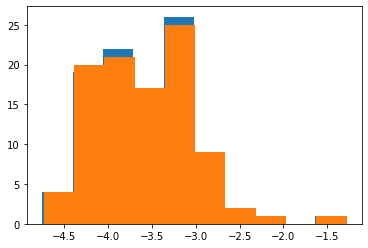

In [195]:
plt.hist(expected[:, 0])
plt.hist(predictive[:, 0])

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+50]]  # 50th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

dirichlet process is great model for unknown and infinite number of clusters - volunteer skill?
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3541698/

https://en.wikipedia.org/wiki/Bhattacharyya_distance

https://www.sciencedirect.com/science/article/pii/S0031320307003123#fd2 for chernoff derivation. They don't like KL distance though, not sure how they can think undefined and tf can derive/include...

r implementation
https://rdrr.io/cran/Compositional/man/kl.diri.html
https://rdrr.io/cran/Compositional/src/R/kl.diri.R

#http://bariskurt.com/kullback-leibler-divergence-between-two-dirichlet-and-beta-distributions/
https://benmoran.wordpress.com/2012/07/11/distances-divergences-dirichlet-distributions/

https://onlinelibrary.wiley.com/doi/book/10.1002/9781119995784 dirichlet book, maybe request dirichlet chapter in a while

http://www.inference.org.uk/mackay/laplace.pdf https://statmodeling.stat.columbia.edu/2009/04/29/conjugate_prior/ can approximate dirichlet with gaussian better in softmax basis - not sure what happens when skewed?


Information theory + chernoff
https://arxiv.org/pdf/1102.2684.pdf

Renyi divergence
https://arxiv.org/pdf/1206.2459.pdf